In [172]:
import os, pandas as pd, slr_pkg.clean_load_data as cld, slr_pkg.para as para
from itertools import combinations
from collections import Counter
from pathlib import Path


# Get current working directory
bp = Path(os.getcwd())

# Set results directory
results_path = bp / "results"

# Set base data directory.
dp  = bp / 'data'
s
# Set sample data directory.
edf_path = dp / 'geotracker_edf_results'
gama_path = dp / 'gama_results'

# Set location data directory.
geo_xy_path = dp / 'geotracker_xy'
gama_xy_path = dp / "gama_xy"

# Ask for county to gather data for.
# area = input('Enter county: ')
area = 'Ventura'
# areas = ['LosAngeles']

In [173]:
# List of contaminants.
chems = para.conts11
samples = pd.read_csv(dp / '{}_clean_samples.csv'.format(area))

In [174]:
samples

,LOGDATE,PARLABEL,PARVAL,PARVQ,UNITS,WID,GID,SID,FIELD_PT_CLASS,LATITUDE,LONGITUDE,chem_name,comp_conc_val,exceedence,magnitude
0,2002-05-16,BZME,31600000.0,=,UG/L,T0611100671-MW-1,"('T0611100671-MW-1', Timestamp('2002-05-16 00:...","(('T0611100671-MW-1', Timestamp('2002-05-16 00...",MW,34.218922,-119.195192,Toluene,150.0,True,210665.666667
1,2010-02-02,BZME,30400.0,=,UG/L,T0611100671-MW-1,"('T0611100671-MW-1', Timestamp('2010-02-02 00:...","(('T0611100671-MW-1', Timestamp('2010-02-02 00...",MW,34.218922,-119.195192,Toluene,150.0,True,201.666667
2,2009-08-20,BZME,30200.0,=,UG/L,T0611100671-MW-1,"('T0611100671-MW-1', Timestamp('2009-08-20 00:...","(('T0611100671-MW-1', Timestamp('2009-08-20 00...",MW,34.218922,-119.195192,Toluene,150.0,True,200.333333
3,2009-11-10,BZME,23300.0,=,UG/L,T0611100671-MW-1,"('T0611100671-MW-1', Timestamp('2009-11-10 00:...","(('T0611100671-MW-1', Timestamp('2009-11-10 00...",MW,34.218922,-119.195192,Toluene,150.0,True,154.333333
4,2005-02-15,BZME,22800.0,=,UG/L,T0611100671-MW-1,"('T0611100671-MW-1', Timestamp('2005-02-15 00:...","(('T0611100671-MW-1', Timestamp('2005-02-15 00...",MW,34.218922,-119.195192,Toluene,150.0,True,151.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824206,2007-09-12,BZ,0.0,ND,UG/L,T0611170069-MW-1,"('T0611170069-MW-1', Timestamp('2007-09-12 00:...","(('T0611170069-MW-1', Timestamp('2007-09-12 00...",MW,34.270324,-118.761674,Benzene,1.0,False,-1.000000
824207,2007-09-12,TCE,0.0,ND,UG/L,T0611170069-MW-1,"('T0611170069-MW-1', Timestamp('2007-09-12 00:...","(('T0611170069-MW-1', Timestamp('2007-09-12 00...",MW,34.270324,-118.761674,Trichloroethene (TCE),5.0,False,-1.000000
824208,2007-09-12,XYLENES,17732.0,=,UG/L,T0611170069-MW-3,"('T0611170069-MW-3', Timestamp('2007-09-12 00:...","(('T0611170069-MW-3', Timestamp('2007-09-12 00...",MW,34.270240,-118.761614,Xylenes (total),1750.0,True,9.132571
824209,2007-09-12,XYLENES,0.0,ND,UG/L,T0611170069-MW-2,"('T0611170069-MW-2', Timestamp('2007-09-12 00:...","(('T0611170069-MW-2', Timestamp('2007-09-12 00...",MW,34.270242,-118.761724,Xylenes (total),1750.0,False,-1.000000


In [175]:
# subset of specific samples meeting parameters.
spec_samples = samples.copy()

# Select spec_samples taken since 2012.
spec_samples = spec_samples.loc[spec_samples['LOGDATE'] >= '2012-01-01']

# Select spec_samples with wells of "monitoring well" type.
spec_samples = spec_samples[(spec_samples['FIELD_PT_CLASS'] == 'MW') | (spec_samples['FIELD_PT_CLASS'] == 'MONITORING')]

# Select samples with contaminants of interest.
spec_samples = spec_samples.loc[spec_samples['PARLABEL'].isin(chems)]

counter = Counter(spec_samples['PARLABEL'])
print(counter.most_common(5))

[('BZME', 10705), ('EBZ', 10705), ('BZ', 10705), ('MTBE', 10308), ('XYLENES', 7745)]


In [176]:
def select_wells(row, c):
    wid = row['WID']
    counter = Counter(row['PARLABEL'])
    if len(counter) == len(c):
        if all(i >= 4 for i in counter.values()):
            return  wid

In [177]:
from collections import namedtuple

result = namedtuple('result', 'wells samples')

In [178]:
c_dict = {}

for i in range(4,12):
    
    c_list = combinations(chems, i)
    c_list = list(c_list)

    for c in c_list:
        df = spec_samples[spec_samples['PARLABEL'].isin(c)].copy()
        grp = df.groupby('WID')['PARLABEL'].apply(list).reset_index()
        res = grp.apply(select_wells, axis=1, c=c)
        res_samples = spec_samples[spec_samples['WID'].isin(res)].copy().reset_index(drop=True)
        s = len(res_samples)
        w = len(res_samples['WID'].unique())
        c_dict[str(sorted(c))] = result(wells=w, samples=s)

In [179]:
cdf = pd.DataFrame.from_dict(c_dict, orient='index').reset_index().rename(columns={'index':'contaminants'})
cdf['c_num'] = cdf['contaminants'].apply(lambda x: len(x.replace('[','').replace(']','').replace("'",'').split(',')))
cdf.sort_values(by='wells', ascending=False, inplace=True)
cdf.reset_index(drop=True, inplace=True)

In [180]:
spec = 'MW'
print('{}, {}: '.format(area, spec))
print(cdf)

Ventura, MW: 
                                           contaminants  wells  samples  c_num
0                         ['BZ', 'BZME', 'EBZ', 'MTBE']    825    72604      4
1                      ['BZ', 'BZME', 'EBZ', 'XYLENES']    636    51261      4
2              ['BZ', 'BZME', 'EBZ', 'MTBE', 'XYLENES']    613    50586      5
3                     ['BZ', 'BZME', 'MTBE', 'XYLENES']    613    50586      4
4                      ['BZ', 'EBZ', 'MTBE', 'XYLENES']    613    50586      4
...                                                 ...    ...      ...    ...
1811  ['EDB', 'MTBE', 'PB', 'TCE', 'TCPR123', 'XYLEN...     35     5521      6
1812  ['BZ', 'BZME', 'EDB', 'PB', 'TCPR123', 'XYLENES']     35     5521      6
1813   ['BZ', 'EBZ', 'EDB', 'PB', 'TCPR123', 'XYLENES']     35     5521      6
1814  ['BZ', 'BZME', 'EBZ', 'MTBE', 'PB', 'TCPR123',...     35     5521      7
1815  ['BZ', 'BZME', 'CD', 'EBZ', 'EDB', 'MTBE', 'PB...     35     5521     11

[1816 rows x 4 columns]


In [181]:
cdf.to_csv(results_path / '{}_MW_contaminant_combos.csv'.format(area))

In [182]:
gbo = cdf.groupby(['c_num'])[['wells','samples']].max()
gbo.reset_index(inplace=True)

In [183]:
maxdf = pd.DataFrame()
for row in gbo.iterrows():
    c_num = row[1][0]
    wells = row[1][1]
    samples = row[1][2]
    print(c_num, wells, samples)
    res = cdf[(cdf['c_num'] == c_num) & (cdf['wells']==wells) &(cdf['samples']==samples)]
    maxdf = maxdf.append(res)


4 825 72604
5 613 55641
6 534 54915
7 499 52735
8 491 51951
9 286 30062
10 122 17999
11 35 5521


In [184]:
maxdf.to_csv(results_path / '{}_{}_contaminant_combos_max.csv'.format(area, spec))

In [185]:
# Run above

# Visualization

In [186]:
import matplotlib.pyplot as plt

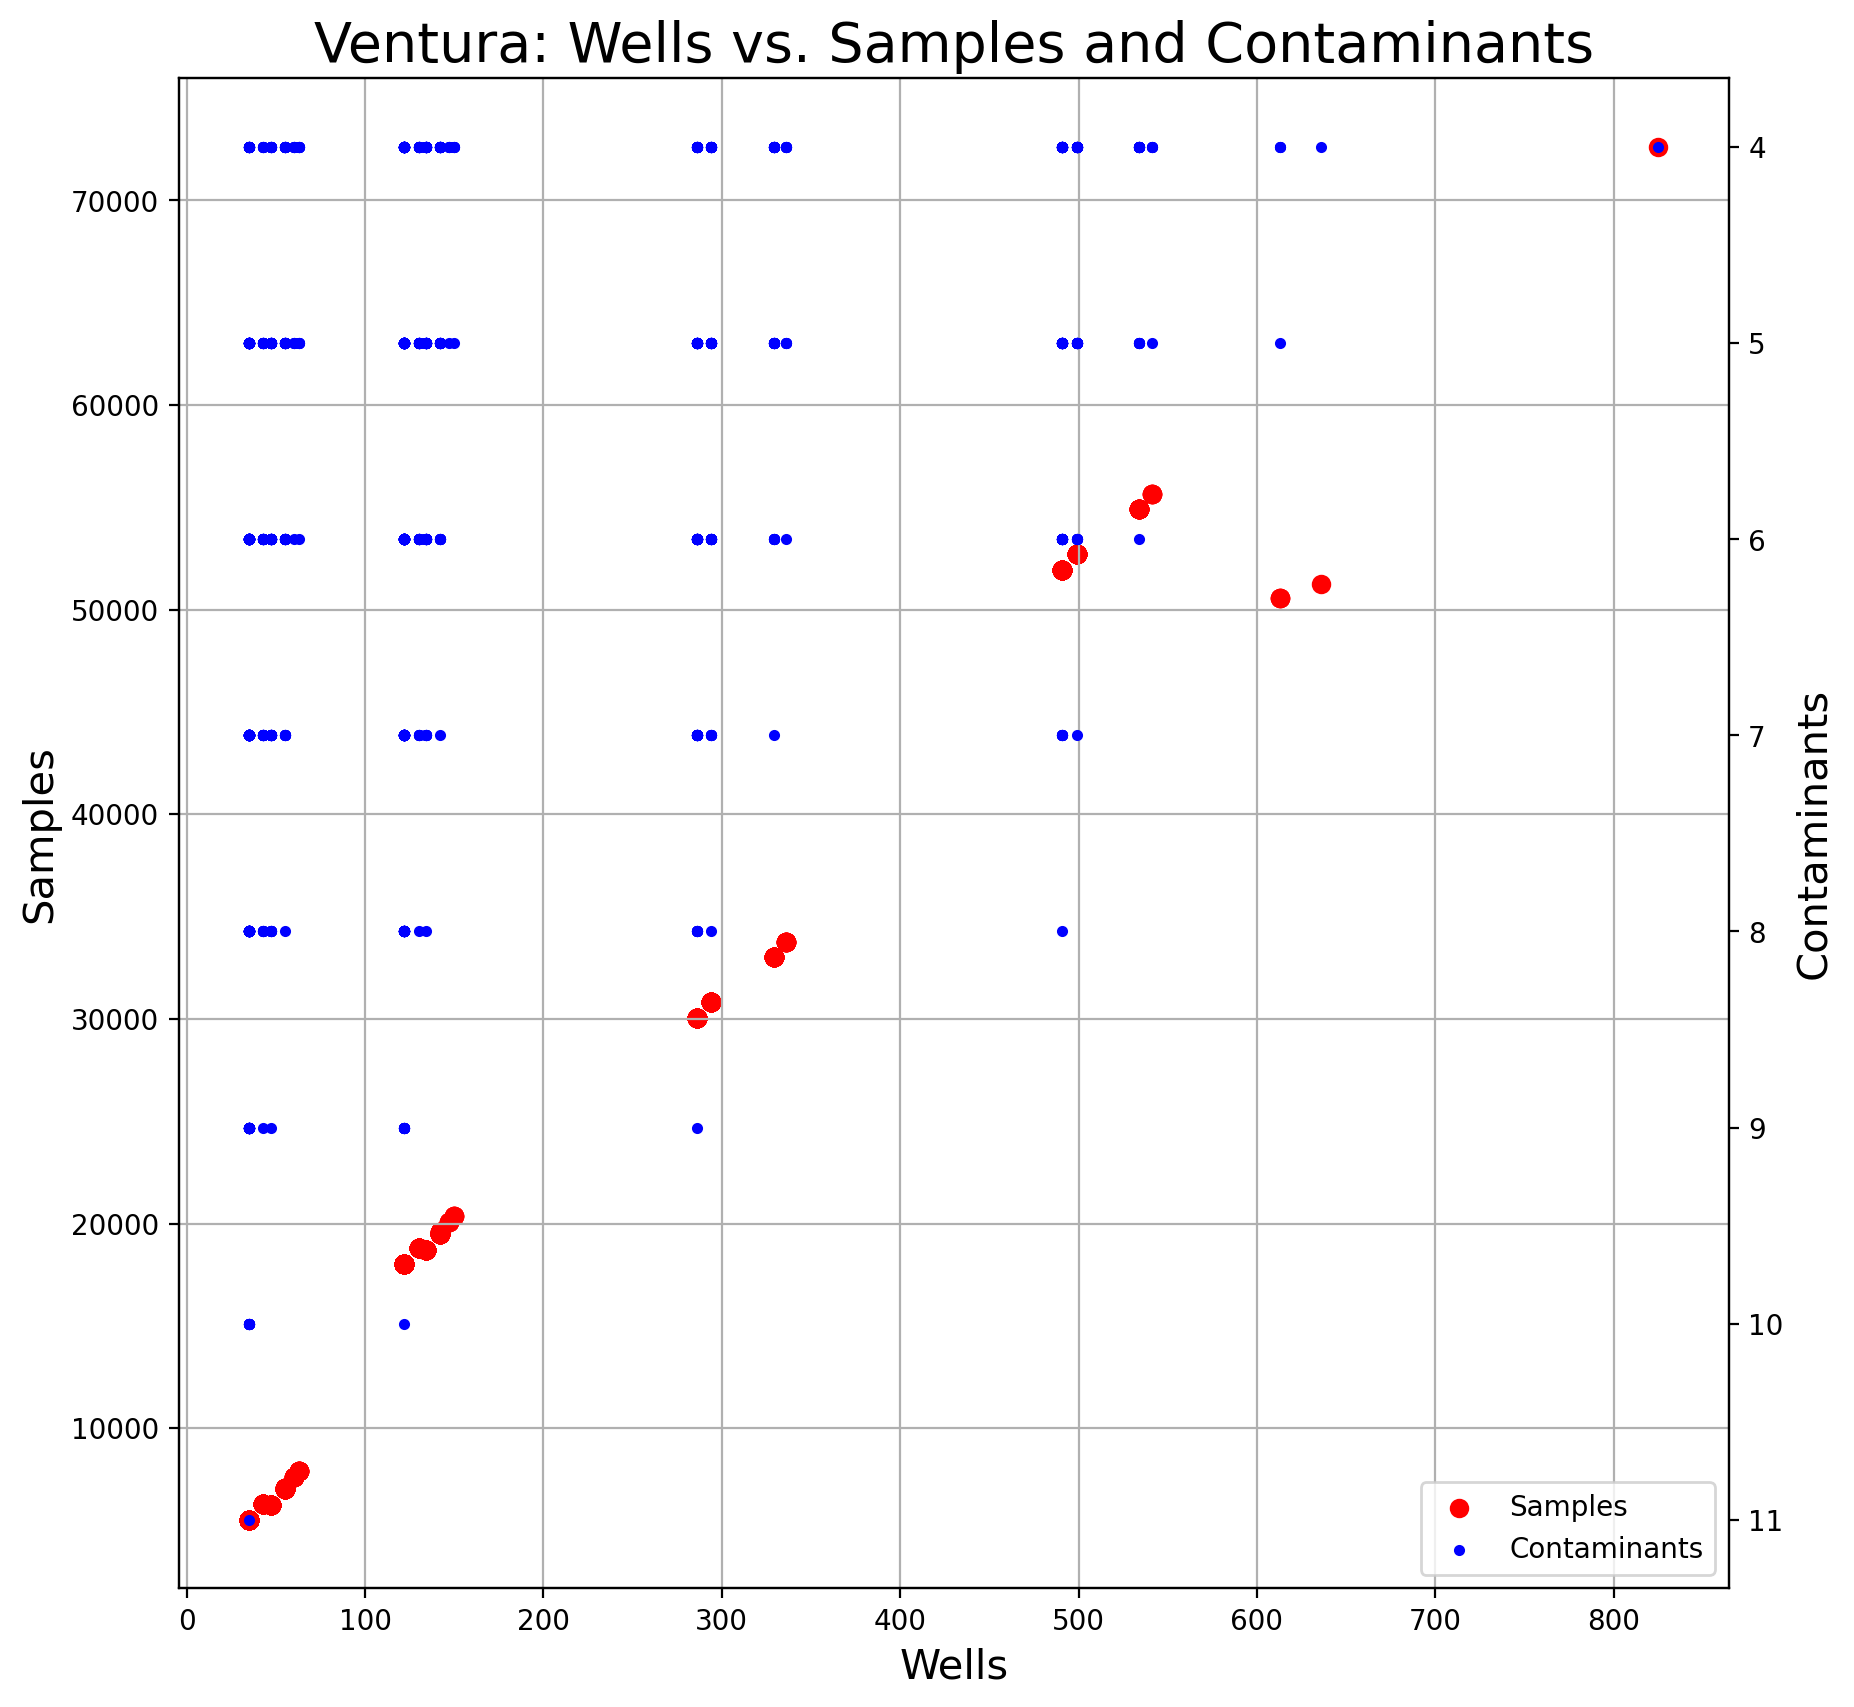

In [187]:
a = c_dict.values()
b = c_dict.keys()

x = cdf['wells']
y = cdf['samples']
z = cdf['c_num']

fig, ax1 = plt.subplots(figsize=(10,10), dpi=200)
p1 =ax1.scatter(x, y, color='red')
ax1.set(xlabel='Wells', ylabel='Samples', title='{}: Wells vs. Samples and Contaminants'.format(area))
ax1.set_xlabel('Wells', fontsize=15)
ax1.set_ylabel('Samples', fontsize=15)
ax1.set_title('{}: Wells vs. Samples and Contaminants'.format(area), fontsize=20)
ax1.grid()
ax2 = ax1.twinx()
p2 = ax2.scatter(x, z, marker='.', color='blue')
ax2.set_ylabel('Contaminants', fontsize=15)
ax2.invert_yaxis()
ax1.legend(handles=[p1, p2], labels=['Samples', 'Contaminants'], loc='lower right')
plt.savefig(results_path / '{}_{}_contaminant_combos.png'.format(area, spec))

In [168]:
cdf.groupby('c_num').max().to_csv(results_path / '{}_c_groups.csv'.format(area))

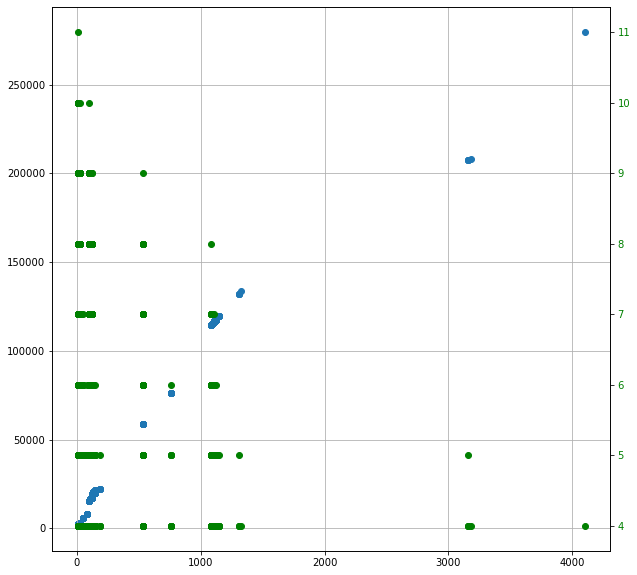

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

x = cdf['wells']
y = cdf['samples']
y2 = cdf['c_num']
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot()
line1 = plt.scatter(x,y)
ax1.grid(True)

ax2 = ax1.twinx()
line2 = ax2.scatter(x, y2, color='green')
ax2.tick_params(axis='y', labelcolor='green')

annots = []
for ax in [ax1, ax2]:
    annot = ax.annotate("", xy=(0,0), xytext=(-20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w", alpha=0.4),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    annots.append(annot)

annot_dic = dict(zip([ax1, ax2], annots))
line_dic = dict(zip([ax1, ax2], [line1, line2]))

def update_annot(line, annot, ind):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text = "x = {}\ny= {}".format(x[ind["ind"][0]], y[ind["ind"][0]])
    annot.set_text(text)

def hover(event):

    if event.inaxes in [ax1, ax2]:
        for ax in [ax1, ax2]:
            cont, ind = line_dic[ax].contains(event)
            annot = annot_dic[ax]
            if cont:
                update_annot(line_dic[ax], annot, ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if annot.get_visible():
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()